In [1]:
%pip install torchinfo
%pip install torchviz

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
# download file to tmp/data.txt
!wget -O tmp/data.txt https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2023-11-21 21:45:17--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8003::154, 2606:50c0:8001::154, 2606:50c0:8002::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8003::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: 'tmp/data.txt'

     0K .......... .......... .......... .......... ..........  4% 1.01M 1s
    50K .......... .......... .......... .......... ..........  9% 1.10M 1s
   100K .......... .......... .......... .......... .......... 13%  822K 1s
   150K .......... .......... .......... .......... .......... 18% 1.07M 1s
   200K .......... .......... .......... .......... .......... 22%  594K 1s
   250K .......... .......... .......... .......... .......... 27%  969K 1s
   300K .......... .......... .......... .......... .......... 32%  834K 1s
  

In [5]:
with open('tmp/data.txt', 'r') as f:
    text = f.read()
print('text length:', len(text))

text length: 1115394


In [6]:
print(text[:100])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


In [7]:
chars = ["[PAD]", *sorted(list(set(text)))]
vocab_size = len(chars)
print("".join(chars))
print("vocab size:", vocab_size)

[PAD]
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
vocab size: 66


In [8]:
# Create mapping from character to index and vice versa
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode("hii there"))
print(decode(encode("hii there")))

[47, 48, 48, 2, 59, 47, 44, 57, 44]
hii there


In [9]:
# store in tensor
data = torch.tensor(encode(text), dtype=torch.int64, device=device)
print(data.shape, data.dtype)
print(data[:100]) # the 100 characters we looked at earier will to the GPT look like this

torch.Size([1115394]) torch.int64
tensor([19, 48, 57, 58, 59,  2, 16, 48, 59, 48, 65, 44, 53, 11,  1, 15, 44, 45,
        54, 57, 44,  2, 62, 44,  2, 55, 57, 54, 42, 44, 44, 43,  2, 40, 53, 64,
         2, 45, 60, 57, 59, 47, 44, 57,  7,  2, 47, 44, 40, 57,  2, 52, 44,  2,
        58, 55, 44, 40, 50,  9,  1,  1, 14, 51, 51, 11,  1, 32, 55, 44, 40, 50,
         7,  2, 58, 55, 44, 40, 50,  9,  1,  1, 19, 48, 57, 58, 59,  2, 16, 48,
        59, 48, 65, 44, 53, 11,  1, 38, 54, 60], device='cuda:0')


In [10]:
# Let's now split up the data into train and validation sets
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

In [11]:
block_size = 100
train_data[:block_size+1]

tensor([19, 48, 57, 58, 59,  2, 16, 48, 59, 48, 65, 44, 53, 11,  1, 15, 44, 45,
        54, 57, 44,  2, 62, 44,  2, 55, 57, 54, 42, 44, 44, 43,  2, 40, 53, 64,
         2, 45, 60, 57, 59, 47, 44, 57,  7,  2, 47, 44, 40, 57,  2, 52, 44,  2,
        58, 55, 44, 40, 50,  9,  1,  1, 14, 51, 51, 11,  1, 32, 55, 44, 40, 50,
         7,  2, 58, 55, 44, 40, 50,  9,  1,  1, 19, 48, 57, 58, 59,  2, 16, 48,
        59, 48, 65, 44, 53, 11,  1, 38, 54, 60,  2], device='cuda:0')

In [12]:
a = train_data[:block_size]
y = train_data[1:block_size+1]

In [13]:
torch.manual_seed(1337)
batch_size = 32 # how many independent sequences will we process in parallel?
block_size = 10 # what is the maximum context length for predictions?

def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

xb, yb = get_batch('train')
print('inputs:')
print(xb.shape, xb.dtype, xb.device)
print('targets:')
print(yb.shape, yb.dtype, yb.device)

inputs:
torch.Size([32, 10]) torch.int64 cuda:0
targets:
torch.Size([32, 10]) torch.int64 cuda:0


In [14]:
class NGramLanguageModel(nn.Module):
    def __init__(self, vocab_size, n):
        super().__init__()
        super().to(device)
        self.n = n
        assert n >= 3, "n should be at least 3"
        embedding_size = int(vocab_size / 1.5 + 10)
        intermediate_size = vocab_size + 10 * n
        self.token_embedding = nn.Embedding(vocab_size, embedding_size, padding_idx=0)
        self.fc = nn.Linear(embedding_size * n, intermediate_size)
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU()
        self.final = nn.Linear(intermediate_size, vocab_size)

    # Create separate function for forward calculation
    def forward(self, x, only_last=False):
        assert len(x.shape) == 2, "input shape should be (batch, time)"

        if only_last:
            # pad time dim to at least n
            x = x[:, -self.n :]
            x = F.pad(x, (self.n - x.shape[1], 0), value=0)
            B, N = x.shape
            x = x.view(B, 1, N)
        else:
            new_x = torch.zeros((x.shape[0], x.shape[1], self.n), dtype=torch.int64, device=device) - 69
            for time_index in range(x.shape[1]):
                row = x[:, max(0, time_index - self.n + 1) : time_index + 1]
                row = F.pad(row, (self.n - row.shape[1], 0), value=0)
                new_x[:, time_index] = row
            x = new_x

        x = self.token_embedding(x)
        x = x.view(x.shape[0], x.shape[1], -1)
        x = self.fc(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.final(x)
        return x

    def loss(self, logits, targets):
        B, T, C = logits.shape
        logits_flat = logits.view(B * T, C)
        loss = F.cross_entropy(logits_flat, targets.view(B * T))
        return loss

    def generate(self, x, max_len_new, temperature=1.0):
        for _ in range(max_len_new):
            logits = self(x, True)[:, -1] / temperature
            probs = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            x = torch.cat([x, next_token], dim=1)

        return x

In [15]:
model = NGramLanguageModel(vocab_size, 7)
summary(
    model,
    input_data=[torch.zeros((256, 10), dtype=torch.long, device=device), True],
    verbose=2,
    device=device,
    col_names=["input_size", "output_size", "num_params", "mult_adds"],
)
model.to(device)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Mult-Adds
NGramLanguageModel                       [256, 10]                 [256, 1, 66]              --                        --
├─Embedding: 1-1                         [256, 1, 7]               [256, 1, 7, 54]           3,564                     912,384
│    └─weight                                                                                └─3,564
├─Linear: 1-2                            [256, 1, 378]             [256, 1, 136]             51,544                    13,195,264
│    └─weight                                                                                ├─51,408
│    └─bias                                                                                  └─136
├─ReLU: 1-3                              [256, 1, 136]             [256, 1, 136]             --                        --
├─Dropout: 1-4                           [256, 1, 136]             [

NGramLanguageModel(
  (token_embedding): Embedding(66, 54, padding_idx=0)
  (fc): Linear(in_features=378, out_features=136, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (relu): ReLU()
  (final): Linear(in_features=136, out_features=66, bias=True)
)

In [16]:
print(model)
# logits, loss = model(xb, yb)
logits = model(xb)
loss = model.loss(logits, yb)
print('logits:', logits.shape)
print('loss:', loss)

print(decode(model.generate(xb, 10)[0].tolist()))

NGramLanguageModel(
  (token_embedding): Embedding(66, 54, padding_idx=0)
  (fc): Linear(in_features=378, out_features=136, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (relu): ReLU()
  (final): Linear(in_features=136, out_features=66, bias=True)
)
logits: torch.Size([32, 10, 66])
loss: tensor(4.2519, device='cuda:0', grad_fn=<NllLossBackward0>)
rch o' theBwCQjc-zY'


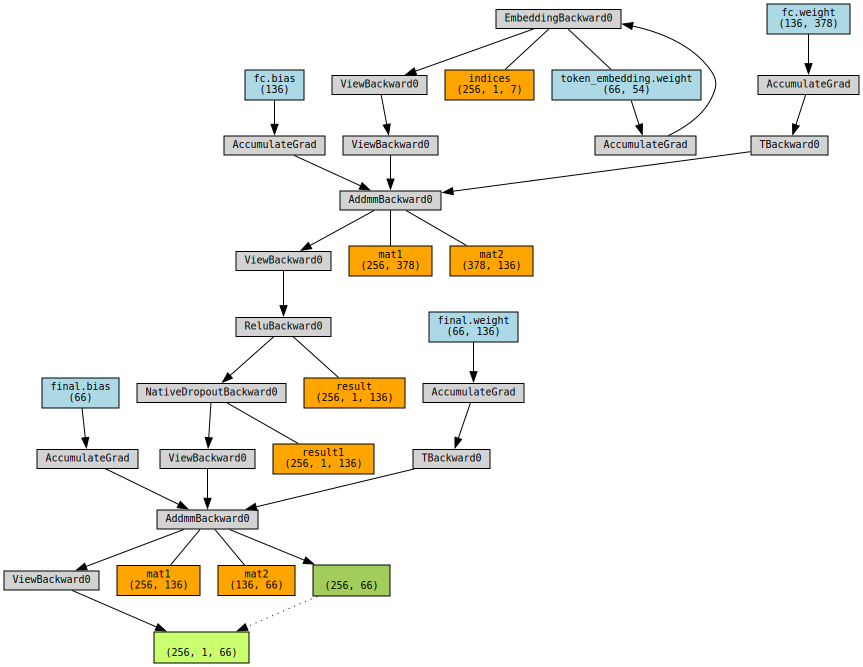

In [30]:
make_dot(model(xb, True), params=dict(model.named_parameters()), show_attrs=False, show_saved=False)

In [18]:
# train the model
optimizer = optim.AdamW(model.parameters(), lr=0.01)
batch_size = 256
for step in range(1001):
    xb, yb = get_batch('train')
    # logits, loss = model(xb, yb)
    logits = model(xb)
    loss = model.loss(logits, yb)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if step % 50 == 0:
        print(f'step: {step}, loss: {loss.item():.3f}')

step: 0, loss: 4.250
step: 50, loss: 2.225
step: 100, loss: 2.102
step: 150, loss: 2.035
step: 200, loss: 2.047
step: 250, loss: 2.028
step: 300, loss: 1.941
step: 350, loss: 1.992
step: 400, loss: 1.954
step: 450, loss: 1.953
step: 500, loss: 1.920
step: 550, loss: 1.884
step: 600, loss: 1.859
step: 650, loss: 1.898
step: 700, loss: 1.945
step: 750, loss: 1.853
step: 800, loss: 1.919
step: 850, loss: 1.924
step: 900, loss: 1.844
step: 950, loss: 1.874
step: 1000, loss: 1.877


In [19]:
for x in model.generate(torch.tensor([encode("LUCENT")] * 5, device=device), 200, 0.9):
    print(decode(x.tolist()))
    print('----')

LUCENTIO:
Gor bepoicense laids.

BRATCLITs:
Arasenty,
For much not the f notgent you lealk, unk and timy to jetling-$gan trean
be of this enfer toous cousluw foldine,
That now look on you to be a bleck ond 
----
LUCENTIO:
Adly amboor his sweter.

prinde,
Or at, tir and of thes that thou  en, fay, sea, it me.

FLORIZEL:
I, he hinds King Catess
appray, have I fiker:
But -thee
you are it peacas: when I see do E'tis lo
----
LUCENTIO:
As aRusat.

GLOUCES:
Beserus I subbrouse thee.

DIONGS:
Where he heart but horse why with burd againser: the good sight.

YORK:
No me with this to mane to are lost am then to ition
And as not
chit
----
LUCENTIO:
Enweed; loe paromy light,
Therent with cult his donwar hatty sew be hereing?

Sarriom,
Yet thou buck
Cate hone and for oparcious! This all to the may beeire not thy seafeno-sider:
Cacony.
Yea, beh
----
LUCENTIUS:
Frobks
Buck as butge:
You defor co their onoure:
I sour seen ships,
In he meareft begas;
Miglomy, oad your to lees to feise to the sight nows

In [20]:
model.generate(torch.tensor([encode("hello")], device=device), 10, 0.0001)

tensor([[47, 44, 51, 51, 54, 62, 44, 57,  2, 59, 47, 44,  2, 58, 58]],
       device='cuda:0')

In [21]:
# save model
import os, json

os.makedirs("tmp/ngram", exist_ok=True)

with open("tmp/ngram/config.json", "w") as f:
    json.dump({"chars": chars, "vocab_size": vocab_size, "n": model.n}, f)

torch.onnx.export(
    model,
    (torch.zeros(1, 1, dtype=torch.int32, device=device), True),
    "tmp/ngram/model.onnx",
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={
        "input": {0: "batch", 1: "time"},
        "output": {0: "batch", 1: "time"},
    },
)

C:\Users\shiva\AppData\Local\Temp\ipykernel_25152\2990080344.py:19: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if only_last:
